In [1]:
import random
import numpy as np
import json
from tqdm import tqdm
from datasets import Dataset

import torch

torch.manual_seed(42)

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig, LlamaModel
import torch
from torch import compile
import torch.nn as nn
from torch import optim
from datasets import load_from_disk
from torch.utils.data import Dataset, DataLoader
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os
import time
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload 2

from transformers import PreTrainedTokenizerFast, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/work/frink/models/llama3-8B-HF")
tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id


import random
import numpy as np
import json
from tqdm import tqdm
from datasets import Dataset

def generate_ravel_dataset(n_samples, split="train", domains=["city"], domain_excluded_attributes=[["Latitude", "Longitude", "Timezone"]], filtering_dict_paths=[None],  seed=42):
            
    # Seed
    random.seed(seed)
    np.random.seed(seed)
    dataset = []
    
    sample_per_domain = n_samples // len(domains)
    
    for domain, excluded_attributes, filtering_dict_path in zip(domains, domain_excluded_attributes, filtering_dict_paths):
                        
        templates = {
            "Language": ["People in %s usually speak"],
            "Country": ["%s is in the country of"],
            "Continent": ["%s is in the continent of"]
        }
        
        prompt_idxs_dict = {
            "Language": [3],
            "Country": [5],
            "Continent": [3]
        }
        
        entities = json.load(open(os.path.join("./data/ravel/", f"ravel_{domain}_entity_attributes.json"), "r"))
        entities_split = json.load(open(os.path.join("./data/ravel/", f"ravel_{domain}_entity_to_split.json"), "r"))
        
        all_attributes = [a for a in list(templates.keys()) if a not in excluded_attributes]

        entities_train = {k: v for k, v in entities.items() if entities_split[k] == "train"}
        name_train = list(entities_train.keys())

        entities_test = {k: v for k, v in entities.items() if entities_split[k] != "train"}
        name_test = list(entities_test.keys())
        
        if split == "train":
            entity_dict, entity_name = entities_train, name_train
        elif split == "test":
            entity_dict, entity_name = entities_test, name_test
        else:
            raise ValueError("split must be 'train' or 'test'")
        
        if filtering_dict_path is not None:
            filtering_dict = json.load(open(filtering_dict_path, "r"))
            filtered_key = []
            
            for entity in filtering_dict.keys():
                model_knows = True
                
                entity_token_len = len(tokenizer(entity)["input_ids"])
                if entity_token_len > 1:
                    model_knows = False
                
                for attribute in all_attributes:                    
                    split_template_idx = [list(filtering_dict[entity][attribute].values())[i] for i in prompt_idxs_dict[attribute]]
                    if True not in split_template_idx:
                        model_knows = False
                        break
                if not model_knows:
                    filtered_key.append(entity)
                
            print(f"Filtering out {len(filtered_key)} out of {len(filtering_dict)} entities that the model does not know!")
            filtering_dict = {k: v for k, v in filtering_dict.items() if k not in filtered_key}
        else:
            filtering_dict = None
        
        for _ in tqdm(range(sample_per_domain)):
            
            data = {}
            
            if filtering_dict is None:
                source_entity, base_entity = random.sample(entity_name, 2)
                attribute = random.choice(all_attributes)
                another_attribute = random.choice(all_attributes)
                source_entity_dict, base_entity_dict = entity_dict[source_entity], entity_dict[base_entity]
                source_template, base_template = random.choice(templates[another_attribute]), random.choice(templates[attribute])
            else:
                source_entity, base_entity = random.sample([k for k in entity_name if k in filtering_dict.keys()], 2)
                attribute = random.choice(all_attributes)
                another_attribute = random.choice(all_attributes)
                source_entity_dict, base_entity_dict = entity_dict[source_entity], entity_dict[base_entity]
                source_template, base_template = random.choice(templates[another_attribute]), random.choice(templates[attribute])
                
            data["input_text"] = base_template % base_entity
            data["entity"] = base_entity
            data["counterfactual_input_text"] = source_template % source_entity
            data["counterfactual_entity"] = source_entity
            data["edit_instruction"] = f"{base_entity} ; {source_entity} - {attribute}"
            data["target"] = base_entity_dict[attribute]
            data["counterfactual_target"] = source_entity_dict[attribute]            
                
            dataset.append(data)
                
    dataset = Dataset.from_list(dataset)
    return dataset


city_train_set = load_from_disk("./data/city_train_set")
city_test_set = load_from_disk("./data/city_test_set")


def ravel_collate_fn(batch):
    
    def tokenize_text_inputs(texts, counterfactual_texts, target_texts, entities=None, counterfactual_entities=None):
        
        input_texts = [text + " " + target for text, target in zip(texts, target_texts)]
        input_texts = [text.replace(" \" ", " \" ") for text in input_texts]
        
        if entities is not None and counterfactual_entities is not None:
            source_entity_position_ids = []
            base_entity_position_ids = []
        
        tokenized = tokenizer(input_texts, return_tensors="pt", padding=True, max_length=50, truncation=True)
        tokenized_counterfactual = tokenizer(counterfactual_texts, return_tensors="pt", padding=True, max_length=50, truncation=True)
        tokenized_labels = []
        
        for i, (input_ids, input_text), in enumerate(zip(tokenized["input_ids"], texts)):
            input_length = tokenizer(input_text, return_tensors="pt", padding=False)["input_ids"].shape[-1]
            label = torch.full_like(input_ids, -100)
            label[input_length:] = input_ids[input_length:]
            label[input_ids == tokenizer.pad_token_id] = -100
            tokenized_labels.append(label)
            
            if entities is not None and counterfactual_entities is not None:
                entity_token = entities[i]
                counterfactual_entity_token = counterfactual_entities[i]
                
                base_entity_position_ids.append([tokenizer.decode(ids).strip() for ids in input_ids].index(entity_token))
                source_entity_position_ids.append([tokenizer.decode(ids).strip() for ids in tokenized_counterfactual["input_ids"][i]].index(counterfactual_entity_token))            
        
        tokenized_labels = torch.stack(tokenized_labels)
        
        return_dict = {
            "base_input_ids": tokenized["input_ids"],
            "base_attention_mask": tokenized["attention_mask"],
            "source_input_ids": tokenized_counterfactual["input_ids"],
            "source_attention_mask": tokenized_counterfactual["attention_mask"],
            "labels": tokenized_labels
        }
        
        if entities is not None and counterfactual_entities is not None:
            return_dict["source_entity_position_ids"] = torch.tensor(source_entity_position_ids)
            return_dict["base_entity_position_ids"] = torch.tensor(base_entity_position_ids)
        
        return return_dict
        
    prompts, edit_instructions, targets, counterfactual_prompts, entities, counterfactual_entities = [], [], [], [], [], []
    for b in batch:
        prompts.append(b["input_text"])
        edit_instructions.append(b["edit_instruction"])
        targets.append(b["counterfactual_target"])
        counterfactual_prompts.append(b["counterfactual_input_text"])
        entities.append(b["entity"])
        counterfactual_entities.append(b["counterfactual_entity"])
        
    editor_input_ids = tokenizer(edit_instructions, return_tensors="pt", padding=True, truncation=True)["input_ids"]
    
    returned_dict = {
        "editor_input_ids": editor_input_ids,
        **tokenize_text_inputs(prompts, counterfactual_prompts, targets, entities=entities, counterfactual_entities=counterfactual_entities),
    }    
    
    return returned_dict

batch_size = 32  # 50 or so
data_loader = DataLoader(
    city_train_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=True
)  # batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(
    city_test_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=True
)

for batch in data_loader:
    break

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Filtering out 3475 out of 3552 entities that the model does not know!


100%|██████████| 1000/1000 [00:00<00:00, 3225.77it/s]


Filtering out 3475 out of 3552 entities that the model does not know!


100%|██████████| 100/100 [00:00<00:00, 7292.54it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [3]:
inspect_ids = 2

source_entity_position_ids = batch["source_entity_position_ids"][inspect_ids]
base_entity_position_ids = batch["base_entity_position_ids"][inspect_ids]

print(f"Source entity position: {source_entity_position_ids}")
print(f"Base entity position: {base_entity_position_ids}")

source_input_ids = batch["source_input_ids"][inspect_ids]
base_input_ids = batch["base_input_ids"][inspect_ids]


Source entity position: 3
Base entity position: 5
tensor([128001,  16298,    304,   2577,   6118,   6604]) <|end_of_text|>People in Bo usually speak
tensor([128001, 128001, 128001, 128001, 128001,  20805,    374,    304,    279,
         32843,    315,  10384]) <|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>Split is in the continent of Africa


In [4]:
# @torch.compile #Apparently this fails when used inside jupyter notebooks but is fine if i make dedicated scripts
from src.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/work/frink/models/llama3-8B-HF",
    num_editing_heads=32,
    intervention_layer=0
)
hypernetwork.load_model("./experiment_models_new/model_epoch_19_step_0.pt")
hypernetwork = hypernetwork.to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
hypernetwork.editor_inner.hypernetwork.model.layers[0].self_attn.q_proj.weight

Parameter containing:
tensor([[ 0.0002, -0.0295, -0.0018,  ...,  0.0011, -0.0469, -0.0220],
        [-0.0135, -0.0698,  0.0023,  ..., -0.0118, -0.0498,  0.0205],
        [-0.0187, -0.0466,  0.0009,  ...,  0.0123, -0.0104,  0.0118],
        ...,
        [-0.0039, -0.0403,  0.0718,  ...,  0.0033, -0.0049,  0.0023],
        [-0.0053, -0.0154,  0.0415,  ...,  0.0040, -0.0048, -0.0011],
        [-0.0035, -0.0168,  0.0304,  ...,  0.0076, -0.0032,  0.0031]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [7]:
hypernetwork.load_model("./experiment_models_new/model_epoch_19_step_0.pt")
hypernetwork = hypernetwork.to("cuda")
hypernetwork.editor_inner.hypernetwork.model.layers[0].self_attn.q_proj.weight

Parameter containing:
tensor([[ 0.0008, -0.0291, -0.0011,  ...,  0.0081, -0.0469, -0.0216],
        [-0.0121, -0.0698,  0.0022,  ..., -0.0117, -0.0498,  0.0205],
        [-0.0188, -0.0466, -0.0016,  ...,  0.0120, -0.0138,  0.0105],
        ...,
        [-0.0042, -0.0403,  0.0718,  ...,  0.0036,  0.0011,  0.0029],
        [-0.0046, -0.0148,  0.0415,  ...,  0.0075, -0.0034,  0.0029],
        [-0.0017, -0.0167,  0.0304,  ...,  0.0084, -0.0035,  0.0056]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [17]:
hypernetwork.eval_accuracy_with_ground_truth_intervention_weight(test_data_loader)

(0.08, 3.784464716911316, [21, 29, 38, 48, 60, 61, 66, 67])

 the, say English


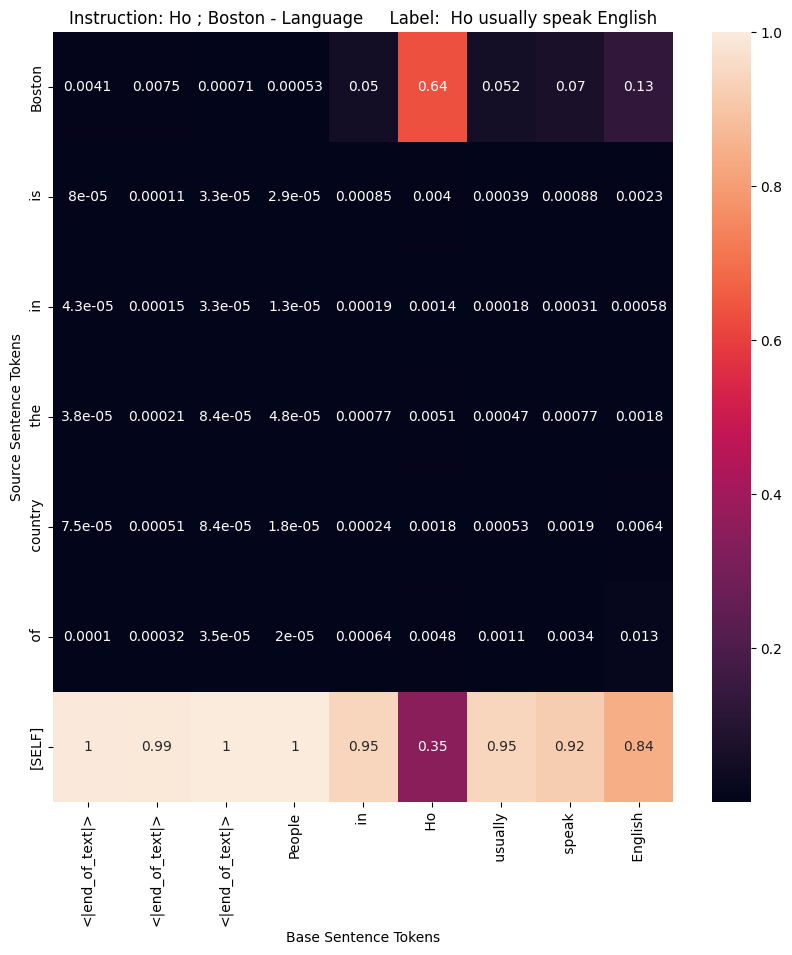

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

batch_id = 1
example_id = 4

batch_size = 10  # 50 or so
data_loader = DataLoader(
    city_train_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=False
)  # batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(
    city_test_set, batch_size=batch_size, collate_fn=ravel_collate_fn, shuffle=False
)

for i, batch in enumerate(test_data_loader):
    if i == batch_id:
        break
    
results = hypernetwork.inspect_batch_prediction_ouptuts(batch)

editor_input_ids = batch["editor_input_ids"][example_id]
base_input_ids = batch["base_input_ids"][example_id]
source_input_ids = batch["source_input_ids"][example_id]
intervention_weight = results["batch_intervention_weight"][example_id]
label = batch["labels"][example_id]

assert intervention_weight.size() == (len(source_input_ids) + 1, len(base_input_ids))

source_axis = [tokenizer.decode([i]) for i in source_input_ids] + ["[SELF]"]
base_axis = [tokenizer.decode([i]) for i in base_input_ids]
editor_text = tokenizer.decode(editor_input_ids)

label_idx = label != -100
label = label[label_idx]
label = tokenizer.decode(label)
pred_output = results["batch_output"][example_id]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(intervention_weight.float().cpu().numpy(), xticklabels=base_axis, yticklabels=source_axis, ax=ax, annot=True)

ax.set_title(f"Instruction: {editor_text}     Label: {label}")
ax.set_xlabel("Base Sentence Tokens")
ax.set_ylabel("Source Sentence Tokens")
print(pred_output)

In [4]:
# current problem: 1728 / 30864
hypernetwork.run_train(
    train_loader=data_loader,
    test_loader=test_data_loader,
    epochs=3,
    eval_per_steps = 50,
    use_unaffected=False
)

tensor(6.8325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.9546, device='cuda:0', grad_fn=<AddBackward0>)


RuntimeError: No active exception to reraise